# COVID Hospital mapping for Ethiopia

In [1]:
# general tools
from preprocessing import get_population_data, split, n_closest_geodetic
import numpy as np
import rasterio
import logging
import pandas as pd
from rasterio.windows import Window
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import box
import requests #http framework to make mhvpl requests for routes
import json # handle response as json
import pickle
log = logging.getLogger(__name__)

## Prepare population data

In [2]:
CRS ='epsg:4326'
LOCATION = 'ethiopia_AOI-1'
DATAPATH = 'data/' + LOCATION
RAWFILEPATH  = DATAPATH +  '/raw'
PROCESSEDFILEPATH = DATAPATH + '/processed'
RESULTSFILEPATH = DATAPATH + '/results'

# Facebooks HRSL dataset
map_file = RAWFILEPATH+"/AOI-1_population_eth_2018-10-01.tif"


In [3]:
#Initial scan the raster map with big windows
origins=pd.DataFrame()
window=2000

with rasterio.open(map_file) as src:
    a=src.xy(0,1)
    for left_x in np.arange(0,src.width,window):
        for top_y in np.arange(0,src.height,window):
            out=get_population_data(map_file,left_x,top_y,window,plot=False)
            if out != {}:
                origins=origins.append([out])
        print("%i/%i\r"%(left_x,src.width),end="")

In [7]:
#Perform a splitting pass
#Run this cell as many times as you want to split the windows
print("%i regions need splitting"%len(origins[origins['split']==True]))
olen=len(origins)
for i in np.arange(olen):
    print("%i/%i\r"%(i+1,olen),end="")
    if origins.iloc[i,origins.columns.get_loc('split')] == True:
        origins.iloc[i,origins.columns.get_loc('split')]='done'
        s=split(map_file,origins.iloc[i])
        origins=origins.append(s,sort=False)
print("We now have %i regions, %i will be split in next round"%(len(origins),len(origins[origins['split']==True])))

84 regions need splitting
We now have 438 regions, 321 will be split in next round


In [8]:
# Keep the regions with population>1
# and filter out the regions which have been split
origins=origins[origins['tot_pop']>0]
origins=origins[origins['split']!='done']
print("We have %i regions of size %i, %i with population >0"%
      (len(origins),min(origins['window']),len(origins[origins['tot_pop']>0])))

We have 321 regions of size 125, 321 with population >0


In [9]:
#transform into GeoDataFrame
origins=gpd.GeoDataFrame(origins,crs=CRS, geometry=[Point(xy) for xy in zip(origins['center_lon'], origins['center_lat'])])
origins.geometry=origins.apply(lambda r: box(r.left_lon, r.bottom_lat, r.right_lon, r.top_lat, ccw=False),axis=1)
origins = origins.reset_index(drop=True)

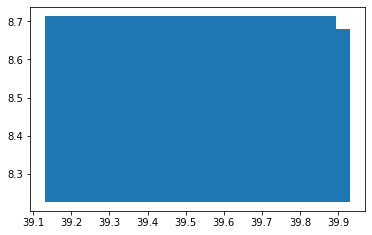

In [10]:
origins.plot()

In [50]:
# save shapefile
origins.to_file(driver = 'GeoJSON', filename= PROCESSEDFILEPATH+'/origins_'+str(len(origins))+'.geojson')
origins.to_file(driver = 'ESRI Shapefile', filename = PROCESSEDFILEPATH+'/origins_'+str(len(origins))+'.shp')

## Import hospital locations

In [11]:
hospital_path = RAWFILEPATH+"/AOI-1_hospitals.shp"
df = gpd.read_file(hospital_path).to_crs(CRS)
df['lon']=df.geometry.centroid.x
df['lat']=df.geometry.centroid.y
df['name']=df['Facility n']
hospitals=df[['name','lon','lat','geometry']]
print("There are %i hospitals"%len(hospitals))
hospitals = hospitals.reset_index(drop=True)


There are 10 hospitals


In [14]:
# Save or load data for later usage
# SAVE
with open(PROCESSEDFILEPATH+'/'+LOCATION+'_'+str(len(origins))+'-h-o.pickle', 'wb') as handle:
    pickle.dump([hospitals,origins], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
# LOAD
with open(PROCESSEDFILEPATH+'/'+LOCATION+'_1278-h-o.pickle', 'rb') as handle:
    hospitals,origins = pickle.load(handle)

In [12]:
# prepare hospital locations to be fed into the OSRM engine as strings
hospitals_loc=";".join([str(i[1])+','+str(i[0]) for i in hospitals[['lat','lon']].values])


## Calculate travel times from each region to the nearest hospital# osrm server address

In [13]:
# osrm server address
osrm_server="http://0.0.0.0:5000"
server=osrm_server+"/table/v1/driving/"
comma="%2C"
Sep="%3B"

batch=100
usual_origin='hospital'

buffer=10/60.  #10 minutes, in hours
overalpenalty=1.05  #5%

# create a new column in the Geodataframe for the time and initilize with -1
origins['t_'+usual_origin]=-1
origins['m_'+usual_origin]=-1

for i in np.arange(origins.shape[0]/batch):
    print("Doing batch %i, [%i,%i] of %i"
          %(i,batch*i,batch*(i+1),origins.shape[0]),end="\r")
    origins_batch=origins.iloc[int(batch*i):].head(n=batch)

    destinations=";".join([str(i[1])+','+str(i[0]) for i in origins_batch[['center_lat','center_lon']].values])
    destinations_number=origins_batch.index

    trail=".json?destinations="+\
    ';'.join([str(x) for x in np.arange(len(hospitals))])+\
    "&sources="+\
    ';'.join([str(x) for x in np.arange(len(hospitals),len(hospitals)+len(origins_batch))])

    fullurl= server+hospitals_loc+";"+destinations+trail
    counter= 0
    response = requests.get(fullurl)
    try:
        response.raise_for_status()
        durations_matrix=json.loads(response.text)['durations']

        durations=[]
        hospital_min=[]
        for origin in np.arange(np.shape(durations_matrix)[0]):
            durations+=[min(durations_matrix[origin])]
            hospital_min+=[np.argmin(durations_matrix[origin])]
        for j in np.arange(len(durations)):
            origins.loc[[destinations_number[j]], ['t_'+usual_origin]]=buffer+durations[j]/60./60.*overalpenalty
            origins.loc[[destinations_number[j]], ['m_'+usual_origin]]=hospital_min[j]

    except:
        counter = counter+1
        continue

In [95]:
osrm_server="http://0.0.0.0:5000"
server=osrm_server+"/table/v1/driving/"

batch=10
POI='hospital'

buffer=10/60.  #10 minutes, in hours
overalpenalty=1.05  #5%

# create a new column in the Geodataframe for the time and distance
origins['t_'+POI]=-1
origins['m_'+POI]=-1

for i in np.arange(origins.shape[0]/batch):
    print("Doing batch %i, [%i,%i] of %i"
          %(i,batch*i,batch*(i+1),origins.shape[0]),end="\r")
    origins_batch=origins.iloc[int(batch*i):].head(n=batch)


    destinations=";".join([str(i[1])+','+str(i[0]) for i in origins_batch[['center_lat','center_lon']].values])
    destinations_number=origins_batch.index

    trail=".json?destinations="+\
    ';'.join([str(x) for x in np.arange(len(hospitals))])+\
    "&sources="+\
    ';'.join([str(x) for x in np.arange(len(hospitals),len(hospitals)+len(origins_batch))])

    fullurl= server+hospitals_loc+";"+destinations+trail
    response = requests.get(fullurl)

    response.raise_for_status()
    durations_matrix=json.loads(response.text)['durations']
    durations=[]
    hospital_min=[]

    for origin in np.arange(np.shape(durations_matrix)[0]):
            durations+=[min(durations_matrix[origin])]
            hospital_min+=[np.argmin(durations_matrix[origin])]
    print(destinations_number)
    for j in np.arange(len(durations)):
            print(destinations_number[j])
            print(durations[j])
            origins.loc[[destinations_number[j]], ['t_'+POI]]=buffer+durations[j]/60./60.*overalpenalty
            origins.loc[[destinations_number[j]], ['m_'+POI]]=hospital_min[j]

    print(len(origins.loc[[0],['t_'+POI]]))
    #except:
    #    logging.warning('Batch '+str(i)+' processing failed. Check if OSRM data covers area.')
    #    continue
    if i==90:
        break

Int64Index([0], dtype='int64')
0
2661.1
321
Int64Index([0], dtype='int64')
0
1968.7
321
Int64Index([0], dtype='int64')
0
1755.6
321
Int64Index([0], dtype='int64')
0
1512.5
321
Int64Index([0], dtype='int64')
0
1380.1
321
Int64Index([0], dtype='int64')
0
1037.5
321
Int64Index([0], dtype='int64')
0
1315.4
321
Int64Index([0], dtype='int64')
0
1380.8
321
Int64Index([0], dtype='int64')
0
2631.2
321
Int64Index([0], dtype='int64')
0
2084.5
321
Int64Index([0], dtype='int64')
0
2484.2
321
Int64Index([0], dtype='int64')
0
2454.9
321
Int64Index([0], dtype='int64')
0
1600.4
321
Int64Index([0], dtype='int64')
0
970.1
321
Int64Index([0], dtype='int64')
0
1470
321
Int64Index([0], dtype='int64')
0
1015.9
321
Int64Index([0], dtype='int64')
0
1416.9
321
Int64Index([0], dtype='int64')
0
1614
321
Int64Index([0], dtype='int64')
0
686.1
321
Int64Index([0], dtype='int64')
0
1067
321
Int64Index([0], dtype='int64')
0
1694
321
Int64Index([0], dtype='int64')
0
1848.2
321
Int64Index([0], dtype='int64')
0
1205.2
32

In [27]:
# TODO: It saves it along the whole column!! All values are being overwritten with one value. Re-check the code!
# save files
origins.to_file(RESULTSFILEPATH+'/origins_'+str(len(origins))+'_results.geojson', driver='GeoJSON')
origins.to_file(RESULTSFILEPATH+'/origins_'+str(len(origins))+'_results.shp', driver='ESRI Shapefile')
with open(RESULTSFILEPATH+'/'+LOCATION+'_'+str(len(origins))+'-results.pickle', 'wb') as handle:
    pickle.dump([hospitals,origins], handle, protocol=pickle.HIGHEST_PROTOCOL)

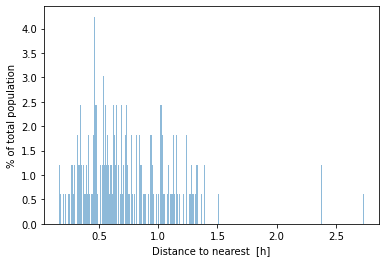

In [14]:
# Plot
%matplotlib inline
plt.figure()
origins['t_'+usual_origin].plot.hist(alpha=0.5,bins=500,cumulative=False,density=True)
plt.ylabel('% of total population')
plt.xlabel('Distance to nearest  [h]')
plt.savefig('travel_time_dist.pdf')
plt.show()

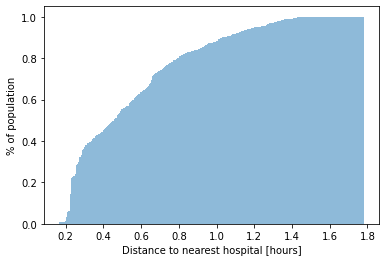

In [110]:
plt.figure()
origins['t_'+usual_origin].plot.hist(alpha=0.5,bins=500,cumulative=True,density=True,weights=origins['tot_pop'])
plt.ylabel('% of population')
plt.xlabel('Distance to nearest '+usual_origin+' [hours]')
plt.show()

In [108]:
for i in np.arange(10,101,10):
    print("El %i%% de la población en Asturias tarda %2.1f minutos en llegar al destino: %s"%
         (i,np.percentile(weight_array(origins['t_'+usual_origin].values*60, origins['tot_pop'].values), i),usual_origin))

NameError: name 'weight_array' is not defined

In [ ]:
lejos=origins[origins['t_'+usual_origin]>1].sort_values(by='t_'+usual_origin,ascending=False)

for index,lugar in lejos.head(n=5).iterrows():
    print("%i personas en %s tardan %2.1f horas en llegar al destino: %s"%
         (lugar["POBLACION"],lugar["NOMBRE"],lugar["t_"+usual_origin],usual_origin))
    get_route_link([hospitales.loc[lugar['m_hospital']]['lon'],hospitales.loc[lugar['m_hospital']]['lat']],
                   [lugar['lon'],lugar['lat']])


origins.to_file("data/origins.geojson", driver="GeoJSON")